* The LayoutLMv2 paper: https://arxiv.org/abs/2012.14740

## Setting up environment

We install HuggingFace Transformers and Detectron2.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/

In [ ]:
!pip install pyyaml

ERROR: Operation cancelled by user


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


We also install PyTesseract:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,816 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

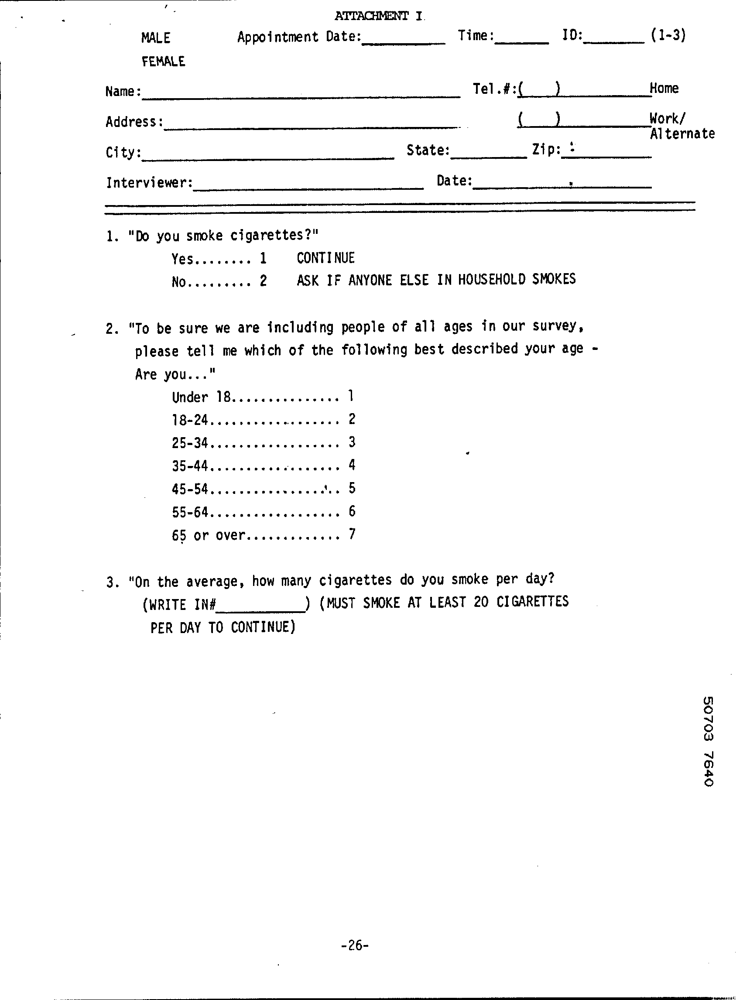

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/drive/MyDrive/rvl_cdip_1000_samples/images/13/image_0009.png")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [ ]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'ATTACHMENT I MALE Appointment Dates, Time: 10:, (1-3) FEMALE Name : Tel.#:( _) Home Address: Work/ ‘Alternate Citys, States, Interviewer: Date: + \'Do you smoke cigarettes?" Yes. ++ 1 CONTINUE No..ssesesee 2 ASK IF ANYONE ELSE IN HOUSEHOLD SMOKES 2. "To be sure we are including people of all ages in our survey, please tell me which of the following best described your age - Are you..." Under 18. 18-24.. 25-34. 35-44 45-54. 55-64.. 65 or over. In the average, how many cigarettes do you smoke per day? (WRITE Tit (MUST SMOKE AT LEAST 20 CIGARETTES PER DAY TO CONTINUE) ovgL €0L0S -26-'


LayoutLMv2Processor uses internal OCR engine to generate inpu_ids, attention_masks,token_type_ids, and bbox for layout and text extraction. However, one can use external OCRs too and plug in the words to the processor. For simplicity, here we use the internal OCR.


In [ ]:

from transformers import LayoutLMv2ImageProcessor, LayoutLMv2TokenizerFast, LayoutLMv2Processor, LayoutLMv2Tokenizer

image_processor = LayoutLMv2ImageProcessor()
print(image_processor)  # apply_ocr is set to True by default
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased") #Not using fast tokenizer as it was less accurate
processor = LayoutLMv2Processor(image_processor, tokenizer)

LayoutLMv2ImageProcessor {
  "apply_ocr": true,
  "do_resize": true,
  "image_processor_type": "LayoutLMv2ImageProcessor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}



In [ ]:
encoded_inputs = processor(image, return_tensors="pt")

In [ ]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 176])
bbox torch.Size([1, 176, 4])
token_type_ids torch.Size([1, 176])
attention_mask torch.Size([1, 176])
image torch.Size([1, 3, 224, 224])


Check whether the input_ids are created correctly by decoding them back to text:

In [ ]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

'[CLS] attachment i male appointment dates, time : 10 :, ( 1 - 3 ) female name : tel. # : ( _ ) home address : work / ‘ alternate citys, states, interviewer : date : +\'do you smoke cigarettes? " yes. + + 1 continue no.. ssesesee 2 ask if anyone else in household smokes 2. " to be sure we are including people of all ages in our survey, please tell me which of the following best described your age - are you... " under 18. 18 - 24.. 25 - 34. 35 - 44 45 - 54. 55 - 64.. 65 or over. in the average, how many cigarettes do you smoke per day? ( write tit ( must smoke at least 20 cigarettes per day to continue ) ovgl €0l0s - 26 - [SEP]'

Note that it also adds the special tokens ([CLS] and [SEP]). You can also pad to a max length, truncate, etc., just like you would do with a regular tokenizer.

## Preprocessing the data using huggingface datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: image_path and label.

In [ ]:
import pandas as pd
import os

dataset_path = "/content/drive/MyDrive/rvl_cdip_1000_samples/images"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'5': 0,
 '14': 1,
 '15': 2,
 '7': 3,
 '8': 4,
 '4': 5,
 '6': 6,
 '3': 7,
 '9': 8,
 '2': 9,
 '10': 10,
 '12': 11,
 '11': 12,
 '0': 13,
 '1': 14,
 '13': 15}

In [ ]:
images = []
labels = []

# Traverse through the directory and its subdirectories
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
            images.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Create a pandas DataFrame
data = {'image_path': images, 'label': labels}
data = pd.DataFrame(data)
data.head()

,image_path,label
0,/content/drive/MyDrive/rvl_cdip_1000_samples/i...,5
1,/content/drive/MyDrive/rvl_cdip_1000_samples/i...,5
2,/content/drive/MyDrive/rvl_cdip_1000_samples/i...,5
3,/content/drive/MyDrive/rvl_cdip_1000_samples/i...,5
4,/content/drive/MyDrive/rvl_cdip_1000_samples/i...,5


In [ ]:
# data.to_excel("/content/drive/MyDrive/datacheck.xlsx")

In [ ]:
from datasets import Dataset

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)

In [ ]:
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 1000
})

In [ ]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
unique_labels = list(set(labels)) #Using set to remove duplicity if any

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(unique_labels), names=unique_labels)
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]

  encoded_inputs = processor(images, padding="max_length", truncation=True)

  # add labels
  # encoded_inputs["labels"] = examples["label"]
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]
  # print(encoded_inputs)

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features,
                              batched=True, batch_size=4)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Next, we set the format to PyTorch tensors. We also specify to put everything on the GPU (CUDA).

In [ ]:
encoded_dataset.set_format(type="torch", device="cuda")

We can create a PyTorch dataloader now:

In [ ]:
import torch

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=8)
batch = next(iter(dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

image torch.Size([8, 3, 224, 224])
input_ids torch.Size([8, 512])
attention_mask torch.Size([8, 512])
token_type_ids torch.Size([8, 512])
bbox torch.Size([8, 512, 4])
labels torch.Size([8])


In [ ]:
processor.tokenizer.decode(batch['input_ids'][1].tolist())

'[CLS] ( and b compound esuuts gu file no : 8128, status : active secielon trees itt 92 - 08 % 25 ( he abstracts. norber : 120 fema mumger : 2109, pi 4, 782 utasenicety vewtcue : z70 % tp vemicle : ssp nee who oral vericle : susp s30 3 / hon tw vehicle : insoluble special instructions : forme suspension in 12¥c mita homogenization anesl es udst : cancelled ( expired - 09 - 17 - 87 ) ps2 : penoiwg 12 - 09 - 87 ‘ tz possp pos - 89 m2 : poss nees arle tu nebative acutor als if loeoung / kgd aales 815 ; fenrles 6121510 - 733 hl males t5005 / ks ; females l7son6 / r p / o males : st + lio plt alo femles : st® le¥o pago ao mele : ral etsng / kglawlsise paa : ho effect tec : slg - etrend effect atrng / kg - lomgsis - pnagno effect tec : mo effect etas % o effect nebrtive peas, nesative f450 ‘ ral negative. wd suppression of the prenary antibody response to srbc. oral perdine 12 - 10 - 87 conetnen 85 tszeorts [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
[batch['labels'][1].item()]

[0]

## Define the model

Here we define the model, namely `LayoutLMv2ForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.

In [ ]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased",
                                                            num_labels=len(labels))
model.to(device)

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## Train the model

Original LR = 5e-5 \\
Set 1e-6 \\
epochs = 30 \\
Optimizer = Adam \\
Loss function preset to be Crossentropy as it is a classification problem
1) First training for 10 epochs to observe loss \\
2) Loss decreasing and accuracy increasing. Trying another 5 epochs \\
3) Another 10+5+3+5+5+3 = 36 epochs in 8 attempts \\

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=3e-6)

global_step = 0
num_train_epochs = 10


#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:423: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

Loss: 7.504261888563633
Training accuracy: 93.60000610351562
Epoch: 1


  0%|          | 0/125 [00:00<?, ?it/s]

Loss: 6.9745043301954865
Training accuracy: 94.60000610351562
Epoch: 2


  0%|          | 0/125 [00:00<?, ?it/s]

Loss: 6.578697616234422
Training accuracy: 95.10000610351562
Epoch: 3


  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Inference

To perform inference on a new document image, 3 things need to be done:

1. prepare the image for the model using `LayoutLMv2Processor`
2. forward pass through the model
3. convert the output of the model to an actual label name

Let's take the first image of the training dataset as an example.

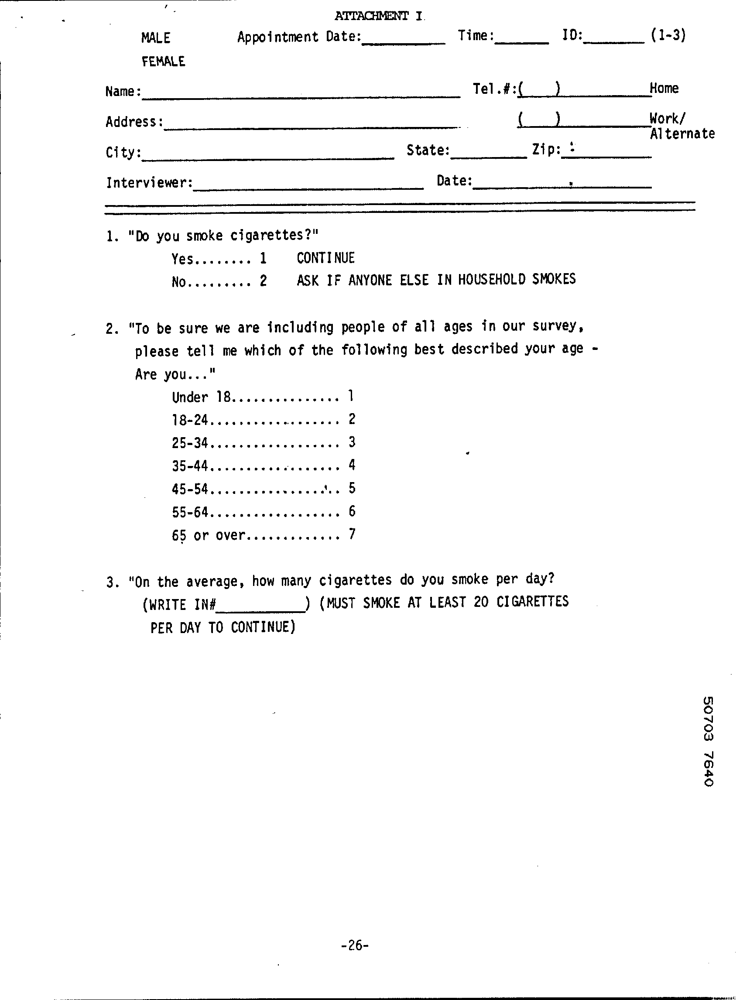

In [ ]:
image

In [ ]:
# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

The model outputs `logits` of shape (batch_size, num_labels):

In [ ]:
logits = outputs.logits
print(logits)
print(logits.shape)

tensor([[-0.1059, -0.9054,  0.4400,  0.2643, -1.0318, -1.4330, -0.9643, -0.7205,
         -1.8218, -0.6237, -0.0216, -0.9627,  0.1802,  0.0883,  0.1410,  3.5628]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 16])


In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: 13


In [ ]:
torch.save(model.state_dict(), 'layoutlmv2_rvl.pt')

# Inference on local weights

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,654 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract
from transformers import LayoutLMv2ForSequenceClassification
import torch
from PIL import Image, ImageDraw
from transformers import LayoutLMv2ImageProcessor, LayoutLMv2TokenizerFast, LayoutLMv2Processor, LayoutLMv2Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

dataset_path = "/content/drive/MyDrive/rvl_cdip_1000_samples/images"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'5': 0,
 '14': 1,
 '15': 2,
 '7': 3,
 '8': 4,
 '4': 5,
 '6': 6,
 '3': 7,
 '9': 8,
 '2': 9,
 '10': 10,
 '12': 11,
 '11': 12,
 '0': 13,
 '1': 14,
 '13': 15}

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


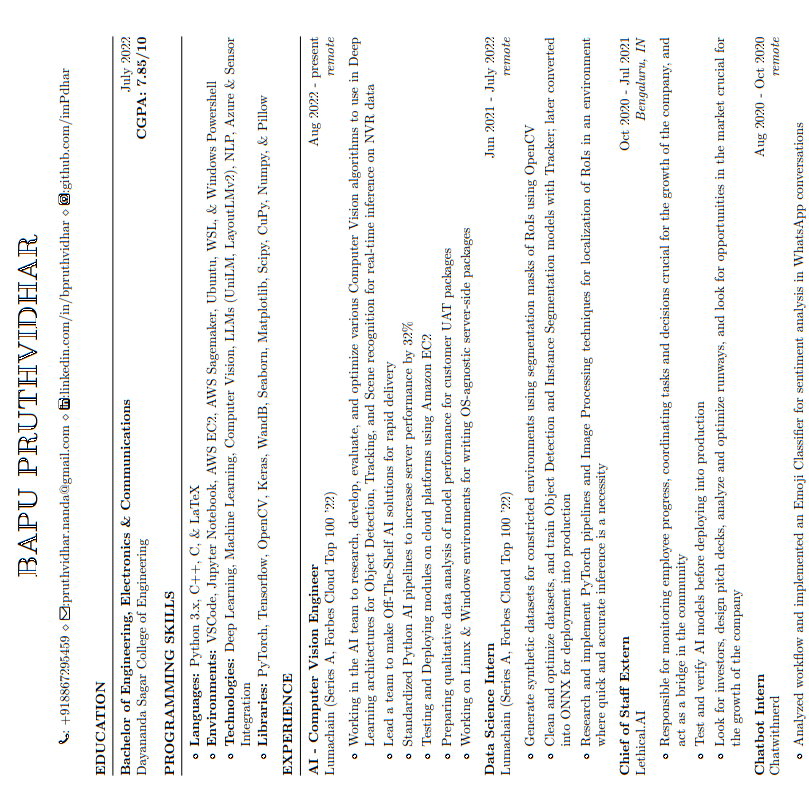

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased",
                                                            num_labels=16) #Base model to import architecture
model.load_state_dict(torch.load('/content/drive/MyDrive/layoutlmv2_rvl_1.pt')) #weights from trained model
image = Image.open("/content/self_resume_sample_rotate.png")
image = image.convert("RGB")
image

In [ ]:



image_processor = LayoutLMv2ImageProcessor()
# print(image_processor)
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(image_processor, tokenizer)

# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt", truncation=True) #Maximum number of tokens is 512, so by truncation, more tokens can be fed in by using different chunks
# print(encoded_inputs)

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)
logits = outputs.logits
# print(logits)
print(logits.shape)
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

torch.Size([1, 16])
Predicted class: 12
